In [276]:
# import basic packages
import pandas as pd
import seaborn as sns
import numpy as np
import os
import yaml
import joblib
import matplotlib.pyplot as plt

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# import train test
from sklearn.model_selection import train_test_split

from util import calculate_disparate_impact, calculate_statistical_parity_difference
from bias_aware_gridsearch import BiasAwareGridSearchCV
sns.set_theme(style="darkgrid")

### Prediction Task: Will an applicant be approved for a home purchase conventional mortgage?

### Data Processing

In [2]:
# read in all mortgage data from 2017
mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')

/var/folders/gp/89jvsfhd6zn10r7krkzw4l7w0000gn/T/ipykernel_4490/2354709147.py:2: DtypeWarning: Columns (34,36,38,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  mort_df = pd.read_csv('hmda_2017_nationwide_all-records_labels.csv')


In [3]:
# dropping columns with only invalid values
mort_df = mort_df.dropna(axis = 1, how = 'all')

In [4]:
mort_df.shape

(14285496, 74)

In [5]:
mort_df.describe()

,as_of_year,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,...,denial_reason_3,rate_spread,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units
count,14285496.0,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428550e+07,1.428046e+07,1.428550e+07,1.428550e+07,1.249445e+07,...,49338.000000,493273.000000,1.428550e+07,1.428550e+07,1.400119e+07,1.400114e+07,1.400119e+07,1.400119e+07,1.400114e+07,1.400114e+07
mean,2017.0,6.809450e+00,1.439923e+00,1.044156e+00,1.845050e+00,1.102287e+00,2.480836e+02,2.796495e+00,2.627451e+00,3.045841e+04,...,5.053833,2.473063,1.999748e+00,1.522989e+00,5.720964e+03,3.273188e+01,7.083347e+04,1.130236e+02,1.465340e+03,2.004188e+03
std,0.0,2.122487e+00,7.467081e-01,2.224088e-01,9.484542e-01,3.172205e-01,1.481113e+03,4.790466e-01,1.931120e+00,1.132808e+04,...,2.680472,1.441981,1.587924e-02,1.087268e+00,3.170171e+03,2.618514e+01,1.494926e+04,4.088793e+01,8.862358e+02,1.099152e+03
min,2017.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.014000e+04,...,1.000000,1.500000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.580000e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.120000e+02,3.000000e+00,1.000000e+00,1.966000e+04,...,3.000000,1.660000,2.000000e+00,1.000000e+00,3.853000e+03,1.173000e+01,6.160000e+04,8.649000e+01,9.260000e+02,1.341000e+03
50%,2017.0,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.850000e+02,3.000000e+00,1.000000e+00,3.278000e+04,...,5.000000,1.900000,2.000000e+00,1.000000e+00,5.161000e+03,2.485000e+01,6.810000e+04,1.077000e+02,1.321000e+03,1.817000e+03
75%,2017.0,9.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,2.900000e+02,3.000000e+00,4.000000e+00,4.014000e+04,...,7.000000,2.490000,2.000000e+00,1.000000e+00,6.784000e+03,4.782000e+01,7.750000e+04,1.331300e+02,1.808000e+03,2.422000e+03
max,2017.0,9.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.400000e+06,3.000000e+00,8.000000e+00,4.978000e+04,...,9.000000,99.990000,2.000000e+00,4.000000e+00,5.381200e+04,1.000000e+02,1.315000e+05,5.074700e+02,1.952900e+04,2.539100e+04


In [147]:
# Removing instances of incomplete/withdrawn and preapproval only applications
inval_obs = [i for i, j in mort_df['action_taken'].items() if j in [1, 3]]
prim_df = mort_df.iloc[inval_obs]

# Limit to only conventional loans for home purchases in California
prim_df = prim_df[(prim_df['loan_purpose'] == 1) & 
                  (prim_df['loan_type'] == 1) & 
                  (prim_df['state_abbr'] == 'CA')]

# Limit demographic data scope to only primary applicants; dropping unnecessary columns
prim_df = prim_df[['action_taken_name', 'action_taken', 'state_name', 
                   'state_abbr', 'applicant_ethnicity_name', 'applicant_ethnicity', 
                   'applicant_race_name_1', 'applicant_race_1', 'applicant_race_name_2', 
                   'applicant_race_2', 'applicant_sex_name', 'applicant_sex', 
                   'applicant_income_000s']]

In [149]:
# Filling invalid values
prim_df = prim_df.reset_index(drop= True)

prim_df = prim_df.replace('Information not provided by applicant in mail, Internet, or telephone application', 
                          'Not applicable')
prim_df = prim_df.fillna(0)

In [154]:
prim_df.shape

(331391, 13)

### EDA

Text(0.5, 1.0, 'Counts of Actions Taken')

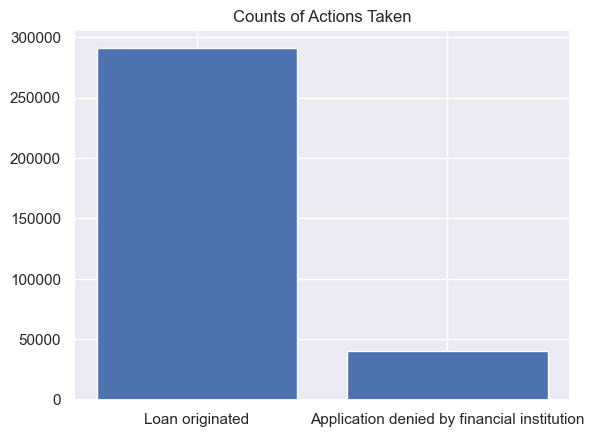

In [279]:
# Action Taken
actions = prim_df['action_taken_name'].value_counts()

plt.bar(actions.index, actions)
plt.title('Counts of Actions Taken')

The chart above depicts the counts of the result of each application, either denial or loan origination. As is shown, this dataset is unbalanced. The negative class, application denial, makes up only 12% of the distribution. For the purposes of this analysis, no further preprocessing will be done to adress this. This will be revisted should the project call for it. 

Text(0.5, 1.0, 'Gender')

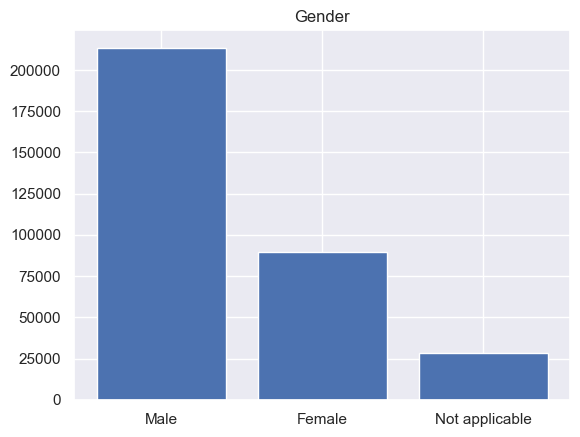

In [280]:
# Sex
gender = prim_df['applicant_sex_name'].value_counts()

plt.bar(gender.index, gender)
plt.title('Gender')

The above chart shows that males make up a majority of primary applicants (~64%). For this project, sex will be analyzed as the protected attribute. The later models will outline whether or not there is bias between sex when it comes to loan origination.

In [232]:
prim_df['applicant_race_name_1'].unique()

array(['Asian', 'Not applicable', 'White', 'Black or African American',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

Text(0.5, 1.0, 'Race')

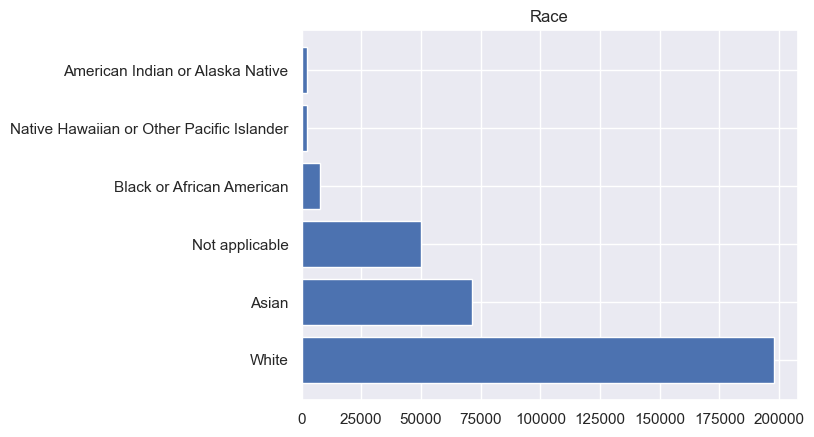

In [281]:
# Race
race = prim_df['applicant_race_name_1'].value_counts()

plt.barh(race.index, race)
plt.title('Race')

Of the race of the primary applicants, White is the most common, making up about 60% of the dataset. It is to be noted that many under this racial group identify as hispanic/latino, which could potentially play a factor in the bias results. The next largest racial group is Asian, which makes up about 21% of the distribution.

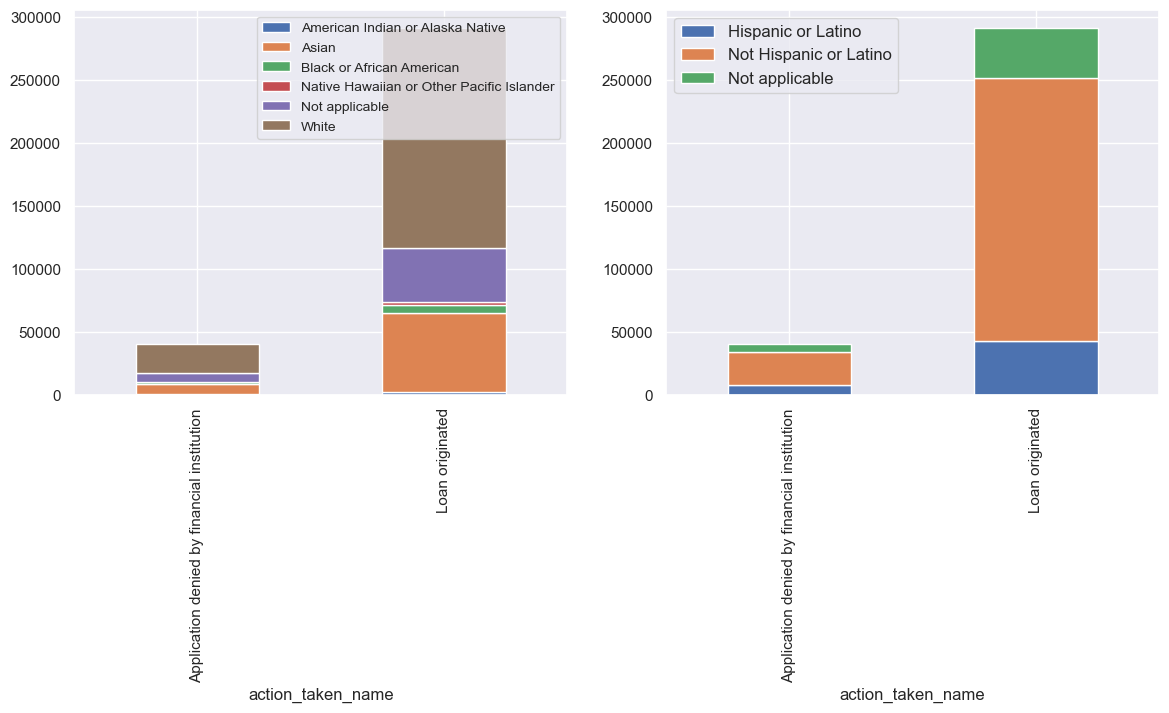

In [283]:
action_by_race = prim_df.groupby(['action_taken_name', 'applicant_race_name_1'])['action_taken'].count()
action_by_eth = prim_df.groupby(['action_taken_name', 'applicant_ethnicity_name'])['action_taken'].count()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

action_by_race.unstack().plot(kind='bar', stacked=True, ax=ax1)
ax1.legend(fontsize = 'small')

action_by_eth.unstack().plot(kind='bar', stacked=True, ax=ax2)
ax2.legend(fontsize = 'medium')

The charts above show the racial and ethnic distributions of the actions taken, denial or loan origination. White, non- Hispanic or Latino applicants are the majority class in this dataset, making up about 45% of the dataset.

In [222]:
race_props = (action_by_race / actions).unstack()
eth_props = (action_by_eth / actions).unstack()

In [225]:
race_props

applicant_race_name_1,American Indian or Alaska Native,Asian,Black or African American,Native Hawaiian or Other Pacific Islander,Not applicable,White
action_taken_name,,,,,,
Application denied by financial institution,0.009021,0.198410,0.035288,0.008971,0.176292,0.572018
Loan originated,0.005897,0.217021,0.022129,0.006674,0.147913,0.600365


This table depicts the specific distribution of the actions taken. Overall, the distribution is similar with the largest differences in the proportion of White (57% vs 60%) and Asian (19% vs 21%) people. This suggests that those racial groups are slightly less likely to be denied a mortgage.

In [224]:
eth_props

applicant_ethnicity_name,Hispanic or Latino,Not Hispanic or Latino,Not applicable
action_taken_name,,,
Application denied by financial institution,0.195601,0.652833,0.151566
Loan originated,0.147508,0.714732,0.137760


This table shows the distributions of ethnic groups. Those who identify as not Hispanic or Latino are overall more likely to have their loan originated (65% vs 71%), the opposite being true for those who idenify as being Hispanic or Latino (19% vs 14%).

### Bias Metrics

In [51]:
X = prim_df.drop(['action_taken_name', 'action_taken', 'applicant_ethnicity_name',
                  'applicant_race_name_2', 'applicant_race_name_1', 'applicant_sex_name', 'state_name'], axis = 1)
y = pd.Series([1 if x != 3 else 0 for x in prim_df['action_taken']], name = 'was_approved')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

In [56]:
train_df = pd.concat([X_train,y_train], axis=1)

In [47]:
calculate_disparate_impact(train_df, 'was_approved', 'applicant_sex', 1, 2)

1.095967568902497

In [38]:
estimator = RandomForestClassifier()
param_grid = {'n_estimators': [250, 400],
              'max_depth': [10, 50],
              'min_samples_split': [2, 4],
              'min_samples_leaf': [2, 4],
             }

In [59]:
gridsearch = GridSearchCV(estimator, param_grid)
gridsearch.fit(X_train, y_train)

^^ have not run on all parameters yet

### Bias Aware Model Building

In [111]:
from os.path import dirname, abspath
script_path = abspath(dirname('params.yaml'))
params_path = os.path.join(script_path, 'params.yaml')

with open(params_path, 'r') as file:
    param_grid_file = yaml.safe_load(file)

In [247]:
param_grid_file['detailed_rfc_params']

{'n_estimators': [50, 100, 200, 500],
 'max_depth': [20, 40, 50, 100],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_leaf_nodes': [20, 30, 40, 50, 100],
 'class_weight': ['balanced', 'balanced_subsample']}

In [114]:
param_grid = param_grid_file['detailed_rfc_params']
estimator = RandomForestClassifier()

grid_search = BiasAwareGridSearchCV(estimator, param_grid, train_df, 'was_approved', 'applicant_sex', 1, 2, verbose= False)
grid_search.fit(X_train, y_train, calculate_disparate_impact)

In [ ]:
# do n_jobs = -2

In [115]:
#joblib.dump(grid_search, 'grid_search_results.pkl')

['grid_search_results.pkl']

In [240]:
opt_model = grid_search.find_optimum_model(3)
opt_preds = opt_model.predict(X_test)
(opt_preds == y_test).mean()

0.7089578049342864

In [161]:
leastb_model = grid_search.select_least_biased_model()
(leastb_model.predict(X_test) == y_test).mean()

0.7076896472215818

In [162]:
bestacc_model = grid_search.select_highest_accuracy_model()
(bestacc_model.predict(X_test) == y_test).mean()

0.7183825224809777

Seems like the least biased model does better in terms of accuracy when compared to the optimum model, which is interesting. This dataset is unbalanced, which is likely a factor in how the models turned out. In total, the gridsearch took around 80 hours to run on about 300,000 rows.

#### Comparing disparate impact

In [243]:
calc_original = X_test.copy()
calc_original['actual'] = y_test
calculate_disparate_impact(calc_original, 'actual', 'applicant_sex', 1, 2)

0.9836212274240939

In [241]:
calc_di = X_test.copy()
calc_di['preds'] = opt_preds
calculate_disparate_impact(calc_di, 'preds', 'applicant_sex', 1, 2)

0.854197612083735

The disparate impact seemed to have improved on the test set after selecting the optimum model using the bias aware grid search

In [244]:
leastb_model

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_leaf_nodes=40, min_samples_leaf=10,
                       min_samples_split=10)

In [245]:
opt_model

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_leaf_nodes=40, min_samples_leaf=10,
                       min_samples_split=10)

In [246]:
bestacc_model

RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=50, max_leaf_nodes=50,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50)

#### 2nd try - BAGS

In [248]:
param_grid = param_grid_file['detailed_rfc_params']
estimator = RandomForestClassifier()

grid_search_p = BiasAwareGridSearchCV(estimator, param_grid, train_df, 'was_approved', 'applicant_sex', 1, 2, n_jobs = -2)
grid_search_p.fit(X_train, y_train, calculate_disparate_impact)

Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Processing parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Proce

In [249]:
# joblib.dump(grid_search_p, 'grid_search_2_results.pkl')

['grid_search_2_results.pkl']

In [270]:
bal_model_p = grid_search_p.select_balanced_model(10)
(opt_model_p.predict(X_test) == y_test).mean()

0.698351394973484

In [273]:
leastb_model_p = grid_search_p.select_least_biased_model()
(leastb_model_p.predict(X_test) == y_test).mean()

0.6985963799861655

In [274]:
bestacc_model_p = grid_search_p.select_highest_accuracy_model()
(bestacc_model_p.predict(X_test) == y_test).mean()

0.7065944201060641

#### Checking disparate impact

In [269]:
# Disparate Impact of original dataset
orig_df = X.copy()
orig_df['actual'] = y
calculate_disparate_impact(orig_df, 'actual', 'applicant_sex', 1, 2)

0.9868568850492966

In [267]:
# for balanced model
full_df = X.copy()
full_df['y_pred'] = bal_model_p.predict(full_df)
calculate_disparate_impact(full_df, 'y_pred', 'applicant_sex', 1, 2)

0.8762652966182988

In [268]:
# for least biased model
full_df = X.copy()
full_df['y_pred'] = leastb_model_p.predict(full_df)
calculate_disparate_impact(full_df, 'y_pred', 'applicant_sex', 1, 2)

0.8501250298765791

After selecting a model using the grid search, disparate impact seems to have had some improvement. The original dataset had a disparate impact of .98, which is extremely high. The grid search selected models which had disparate impacts of .87 for the most balanced model, and .85 for the least biased model.

### Conclusions

Ima do a rerun of everything to get it cleaned up, then I'll take a look at the charts for the parameters